In [1]:
from epigenomic_dataset import load_epigenomes
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

# The considered window size
window_size = 200
cell_line="HEK293"
regions="promoters"

# Retrieving the input data
X, y = load_epigenomes(
    cell_line = cell_line,
    dataset = "fantom",
    regions = regions,
    window_size = window_size
)

y = y.values.ravel()

# Imputation of NaN Values
X[X.columns] = KNNImputer(n_neighbors=X.shape[0]//10).fit_transform(X)

# Robust normalization of the values
X[X.columns] = RobustScaler().fit_transform(X)

X = X.values
shape=X.shape[1]

# Here one should feature selection. How can we do this?

In [2]:
from typing import Dict, Tuple, List

class Model:
    def __init__(self, name: str, model, **kwargs):
        self.name = name
        self.model = model
        self.kwargs = kwargs
        
    def __str__(self) -> str:
        return self.name
    
    def __repr__(self) -> str:
        return self.name
    
    def get_model(self) -> Tuple:
        return (self.model, self.kwargs)

In [3]:
from sklearn.tree import DecisionTreeClassifier

def get_decision_tree(name: str = 'DecisionTree', criterion: str = 'gini', max_depth: int = 50, 
                      random_state: int = 42, class_weight: str = 'balanced', **kwargs) -> Model:
    model = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        random_state=random_state,
        class_weight=class_weight
    )
    return Model(name, model, **kwargs)

Model.DecisionTree = get_decision_tree

In [4]:
Model.DecisionTree()

DecisionTree

In [5]:
from sklearn.ensemble import RandomForestClassifier
from multiprocessing import cpu_count


def get_random_forest(name: str = 'RandomForest', n_estimators: int = 500, criterion: str = 'gini', 
                      max_depth: int = 30, random_state: int = 42, 
                      class_weight: str = 'balanced', n_jobs: int = cpu_count, **kwargs):
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        random_state=random_state,
        class_weight=class_weight,
        n_jobs=n_jobs
    )
    return Model(name, model, **kwargs)

Model.RandomForest = get_random_forest

In [6]:
Model.RandomForest()

RandomForest

In [7]:
from tensorflow.keras.layers import Layer, Input, Flatten, Reshape, Dense, Conv2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from sklearn.model_selection import StratifiedShuffleSplit


C:\Users\matte\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\matte\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\matte\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\matte\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [8]:
from tensorflow.keras.layers import AlphaDropout, ThresholdedReLU

In [9]:
from tensorflow.keras.models import Sequential

def get_sequential(default_name: str = 'Sequential'):
    # no first and last layer
    def get_layers(*layers: Tuple[Layer]):
        def get_model(input_shape: Tuple[int], name: str = None, optimizer: str = 'nadam', 
                      loss: str = 'binary_crossentropy', metrics: List = None,
                      epochs: int = 1000, batch_size: int = 1024, 
                      validation_split: float = 0.1, shuffle: bool = True, verbose: bool = False, 
                      callbacks: List = None, **kwargs):
            name = name or default_name
            input_layer = Input(shape=input_shape)
            output_layer = Dense(1, activation="sigmoid")
            model = Sequential((input_layer,) + layers + (output_layer,), name)
            
            matrics = metrics or [
                "accuracy",
                AUC(curve="ROC", name="auroc"),
                AUC(curve="PR", name="auprc")
            ]
            model.compile(
                optimizer=optimizer,
                loss=loss,
                metrics=metrics
            )
            
            kwargs.update({
                'epochs': epochs,
                'batch_size': batch_size,
                'validation_split': validation_split,
                'shuffle': shuffle,
                'verbose': verbose,
                'callbacks': callbacks
            })
            model.summary()
            return Model(name, model, **kwargs)
        return get_model
    return get_layers

Model.Sequential = get_sequential()

In [10]:
Model.Sequential()((104,20))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "Sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 104, 1)            21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


Sequential

In [11]:
Model.Perceptron = get_sequential('Perceptron')()

In [12]:
Model.Perceptron((104,))

Model: "Perceptron"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 105       
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


Perceptron

In [13]:
Model.MLP = get_sequential('MLP') 
Model.FFNN = get_sequential('FFNN')
Model.CNN = get_sequential('CNN')

In [14]:
#training 20 sec 
Model.MLP_Epi = Model.MLP(
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
)

In [15]:
#training 40 sec
Model.FFNN_Epi = Model.FFNN(
    Dense(256, activation="relu"),
    Dense(128),
    BatchNormalization(),
    Activation("relu"),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
)

In [16]:
#test con Alphadropout e ThresholdedReLU
Model.FFNN_Epi_2 = Model.FFNN(
    Dense(256, activation="relu"),
    Dense(128),
    BatchNormalization(),
    ThresholdedReLU(0.05),
    Dense(64, activation="relu"),
    AlphaDropout(0.3), #new
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
)

In [17]:
#test con
Model.FFNN_Epi_3 = Model.FFNN(
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    BatchNormalization(),
    ThresholdedReLU(0.05),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    AlphaDropout(0.5), #new
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
)

In [18]:
Model.MLP_Seq = Model.MLP(
    Flatten()
)(input_shape=(200, 4))

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 801       
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


In [19]:
Model.FFNN_Seq = Model.FFNN(
    Flatten(),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
)(input_shape=(200, 4))

Model: "FFNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               102528    
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 32)                2080   

In [20]:
Model.CNN_Seq = Model.CNN(
    Reshape((200, 4, 1)),
    Conv2D(64, kernel_size=(10, 2), activation="relu"),
    Conv2D(64, kernel_size=(10, 2), activation="relu"),
    Dropout(0.3),
    Conv2D(32, kernel_size=(10, 2), strides=(2, 1), activation="relu"),
    Conv2D(32, kernel_size=(10, 1), activation="relu"),
    Conv2D(32, kernel_size=(10, 1), activation="relu"),
    Dropout(0.3),
    Flatten(),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
)(input_shape=(200, 4))

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 200, 4, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 191, 3, 64)        1344      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 182, 2, 64)        81984     
_________________________________________________________________
dropout_3 (Dropout)          (None, 182, 2, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 1, 32)         40992     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 78, 1, 32)         10272     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 69, 1, 32)         10272   

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

splits = 50 #da testare un numero diverso di split
holdouts = StratifiedShuffleSplit(n_splits=splits, test_size=0.2, random_state=42)


In [22]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, average_precision_score
from sanitize_ml_labels import sanitize_ml_labels
import numpy as np

def report(y_true:np.ndarray, y_pred:np.ndarray)->np.ndarray:
    integer_metrics = accuracy_score, balanced_accuracy_score
    float_metrics = roc_auc_score, average_precision_score
    results1 = {
        sanitize_ml_labels(metric.__name__): metric(y_true, np.round(y_pred))
        for metric in integer_metrics
    }
    results2 = {
        sanitize_ml_labels(metric.__name__): metric(y_true, y_pred)
        for metric in float_metrics
    }
    return {
        **results1,
        **results2
    }

#si usano solo per categorizzazione, non hanno senso per regressione
# auroc: area sotto la curva di Receiver operating characteristic: analizza falsi positivi e negativi
# valore minimo è 0.5 (non impara niente)  valore massimo è 1 (modello perfetto)
# auprc: area sotto la curva di precision recall: va a computare per diversi treashold di precisioni diversi, la somma delle aree
#sottese sotto i diversi traingolini della precision-reacall. Un modello che non impara nulla ha AUPRC = 0 e un modello perfetto ha
# AUPRC = 1

In [23]:
def precomputed(results, model:str, holdout:int)->bool:
    df = pd.DataFrame(results)
    if df.empty:
        return False
    return (
        (df.model == model) &
        (df.holdout == holdout)
    ).any()

In [24]:
models=[]

models.append(Model.MLP_Epi((shape,),name="MLP"))
models.append(Model.FFNN_Epi((shape,),name="FFNN"))
models.append(Model.FFNN_Epi_2((shape,),name="FFNN_test1"))
models.append(Model.FFNN_Epi_3((shape,),name="FFNN_test2"))

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               26624     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 33        
Total params: 36,993
Trainable params: 36,993
Non-trainable params: 0
_________________________________________________________________
Model: "FFNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               53248     
_____________________________________________

In [25]:
from tqdm.auto import tqdm
import pandas as pd

In [28]:
import json
import compress_json
import os
if os.path.exists("results_HEK293_promoters.json"):
    with open('results_HEK293_promoters.json') as json_file:
        results = json.load(json_file)
else:
    results = []
    
    for i, (train, test) in tqdm(enumerate(holdouts.split(X, y)), total=splits, desc="Computing holdouts", dynamic_ncols=True):
        for model, params in tqdm([model.get_model() for model in models], total=len(models), desc="Training models", leave=False, dynamic_ncols=True):
            model_name = (
                model.__class__.__name__
                if model.__class__.__name__ != "Sequential"
                else model.name
            )
            if precomputed(results, model_name, i):
                continue
            model.fit(X[train], y[train], **params)
            results.append({
                "model":model_name,
                "run_type":"train",
                "holdout":i,
                **report(y[train], model.predict(X[train]))
            })
            results.append({
                "model":model_name,
                "run_type":"test",
                "holdout":i,
                **report(y[test], model.predict(X[test]))
            })
            compress_json.local_dump(results, f"results_{cell_line}_{regions}.json")

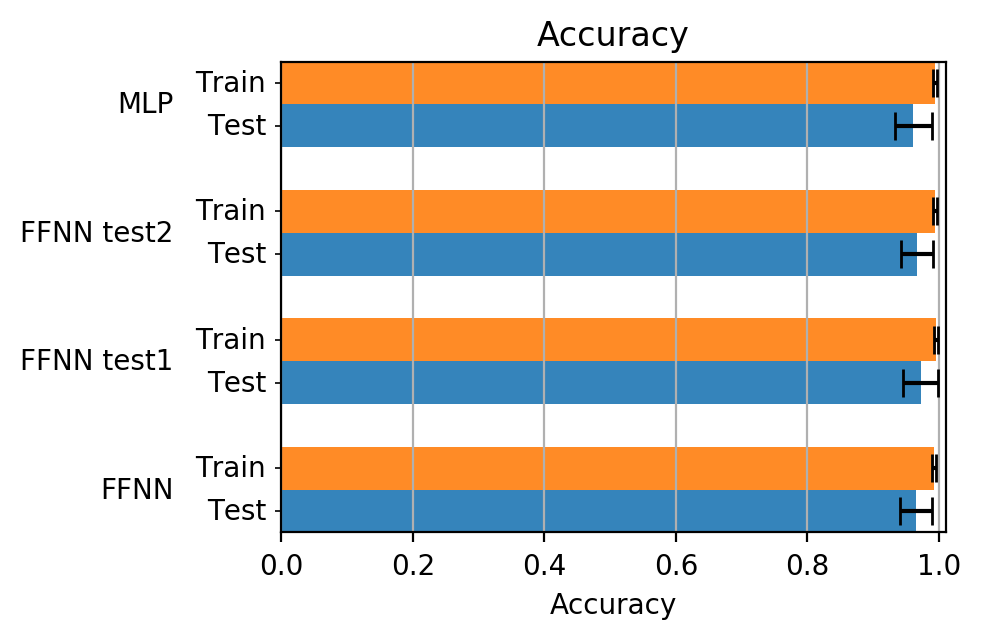

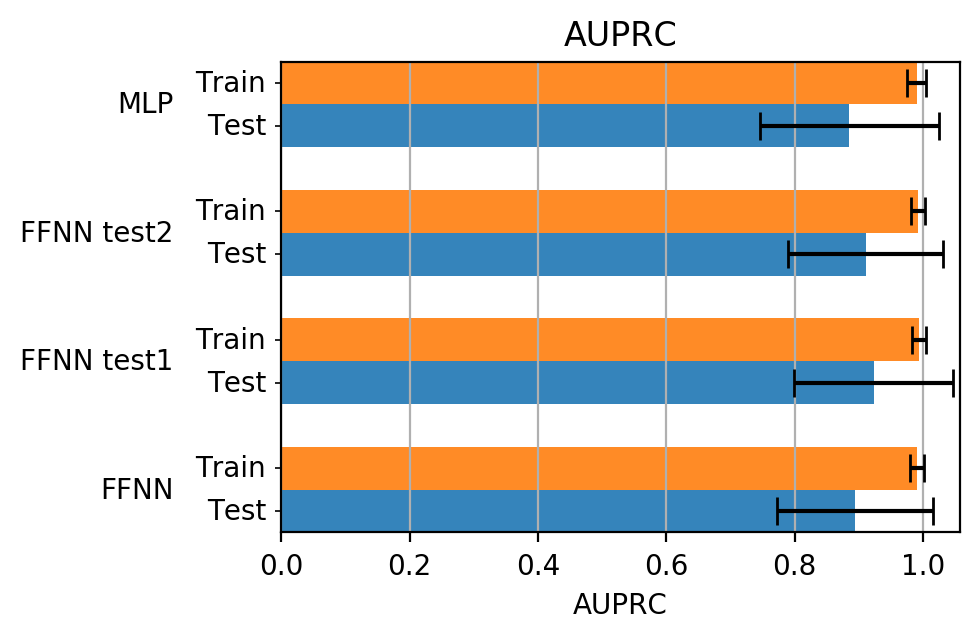

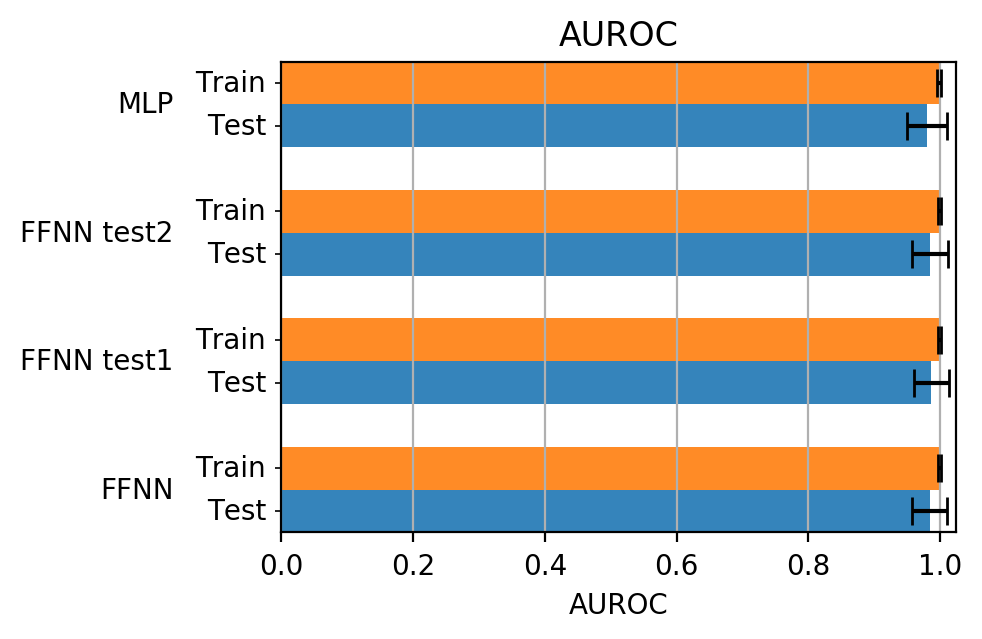

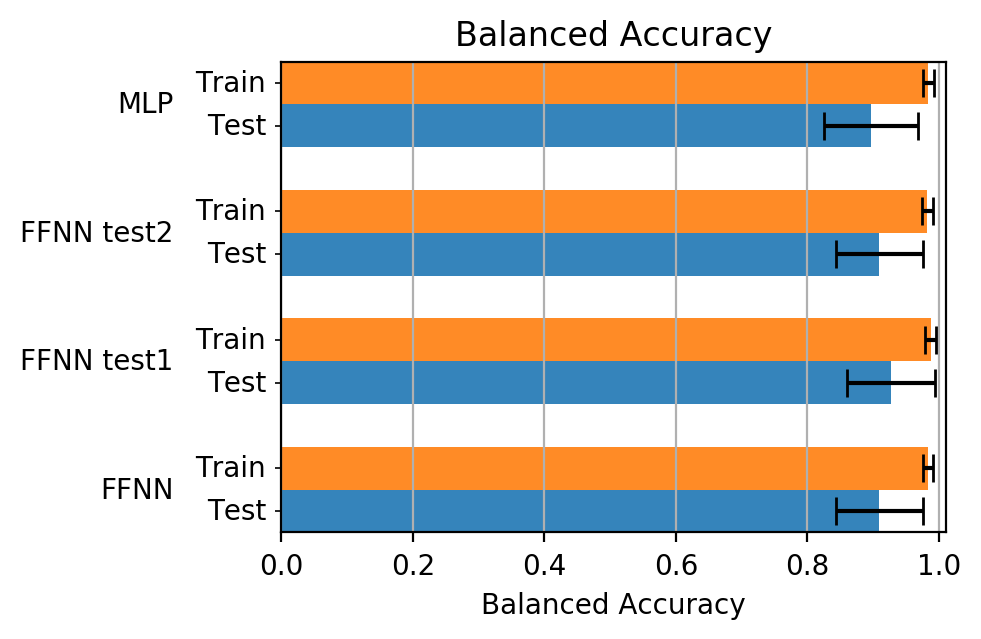

In [29]:
from barplots import barplots
df = pd.DataFrame(results)
df = df.drop(columns=["holdout"])
df[:5]


barplots(
    df,
    groupby=["model", "run_type"],
    show_legend=False,
    height=5,
    orientation="horizontal"
)

from PIL import Image
from glob import glob

for x in glob("barplots/*.png"):
    display(Image.open(x))

In [37]:
from scipy.stats import wilcoxon

# Here we will be doing a statistical test.
models = df[
    (df.run_type == "train")
]

mlp_scores = models[models.model=="MLP"]
FFNN_scores = models[models.model=="FFNN"]
FFNNt1_scores = models[models.model=="FFNN_test1"]
FFNNt2_scores = models[models.model=="FFNN_test2"]
alpha = 0.01

for metric in mlp_scores.columns[-4:]:
    print(metric)
    a,  b = FFNN_scores[metric], FFNNt2_scores[metric]
    stats, p_value = wilcoxon(a, b)
    if p_value > alpha:
        print(p_value, "The two models performance are statistically identical.")
    else:
        print(p_value, "The two models performance are different")
        if a.mean() > b.mean():
            print("The first model is better")
        else:
            print("The second model is better")

Accuracy
9.059934411677675e-10 The two models performance are different
The second model is better
Balanced Accuracy
0.0007413258442797535 The two models performance are different
The first model is better
AUROC
2.6489035224744964e-06 The two models performance are different
The second model is better
AUPRC
2.228554183152968e-09 The two models performance are different
The second model is better
